In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [2]:
df=pd.read_csv('EV_cars_India_2023.csv')

In [3]:
df.head()

,Car_name,Car_price,Batter_cap,Drive_range,Power,Charge_time,transmission,Boot_space,Top_speed
0,MG Comet EV,7.98 lakh,17.3 kWh,230 km/full charge,41.42 Bhp,7 Hours,Automatic,NaN,NaN
1,Tata Tiago EV,8.69 - 11.99 lakh,19.2 KWh,250 km/full charge,60.34 - 73.75 Bhp,58 Min(10-80%),240 L (Liters),Automatic,NaN
2,Tata Tigor EV,12.49 - 13.75 lakh,26 kWh,315 km/full charge,73.75 Bhp,7.5h,316 L (Liters),Automatic,NaN
3,MG ZS EV,23.38 - 27.40 lakh,50.3 kWh,461 km/full charge,174.33 Bhp,8.5 to 9 Hours,Automatic,NaN,NaN
4,BYD Atto 3,33.99 - 34.49 lakh,60.48 kWh,521 km/full charge,201.15 Bhp,9.5-10 Hours,440L L (Liters),Automatic,NaN


In [4]:
df.shape

(30, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Car_name      30 non-null     object
 1   Car_price     30 non-null     object
 2   Batter_cap    27 non-null     object
 3   Drive_range   30 non-null     object
 4   Power         30 non-null     object
 5   Charge_time   30 non-null     object
 6   transmission  28 non-null     object
 7   Boot_space    12 non-null     object
 8   Top_speed     6 non-null      object
dtypes: object(9)
memory usage: 2.2+ KB


In [6]:
df.isnull().sum()

Car_name         0
Car_price        0
Batter_cap       3
Drive_range      0
Power            0
Charge_time      0
transmission     2
Boot_space      18
Top_speed       24
dtype: int64

In [7]:
df.drop(['Boot_space','Top_speed'],axis=1,inplace=True)

In [8]:
df['transmission'].fillna(df['transmission'].mode()[0],inplace=True)

###  Data Preprocessing

In [9]:
df['Batter_cap'].unique()

array(['17.3 kWh', '19.2 KWh', '26 kWh', '50.3 kWh', '60.48 kWh',
       '39.2kWh', '34.5 kWh', '40.5 kWh', '71.7 kWh', '29.2 kWh',
       '77.4 kWh', '200kmph', nan, '32.6KwH', '107.8kwh', '93.4kWh',
       '83.9Kw'], dtype=object)

In [10]:
def normalize_units(value):
    if pd.isna(value):
        return np.nan
    value=value.lower().strip()
    if 'kwh' in value or 'kw' in value: # check for valid battery capacity units
        return float(value.split()[0].replace('kwh','').replace('kw',''))
    elif 'kmph' in value:
        return np.nan   # Invalid unit for battery capacity, treat as NaN
    return np.nan

df['Batter_cap']=df['Batter_cap'].apply(normalize_units)

median_value=df['Batter_cap'].median()
df['Batter_cap'].fillna(median_value,inplace=True)




In [11]:
df.rename(columns={'Batter_cap': 'Batter_cap (kWh)'}, inplace=True)


In [12]:
df['Car_price'].unique()

array(['7.98  lakh', '8.69 - 11.99  lakh', '12.49 - 13.75  lakh',
       '23.38 - 27.40  lakh', '33.99 - 34.49  lakh',
       '23.84 - 24.03  lakh', '15.99 - 18.99  lakh',
       '16.49 - 19.54  lakh', '1.59 - 2.4 lakh', '1.7 cr',
       '73.90 - 77.50  lakh', '29.15  lakh', '1.53 - 2.3 lakh', '1.9 cr',
       '9.13 - 9.46  lakh', '4.50  lakh', '14.49 - 17.19  lakh',
       '44.95  lakh', '60.95 - 65.95  lakh', '1.2 cr', '52.50  lakh',
       '1.02 - 1.2 lakh', '11.50 - 12.76  lakh', '56.90  lakh',
       '1.20 - 1.2 lakh', '39.50  lakh', '4.79  lakh', '74.50  lakh',
       '99.50  lakh'], dtype=object)

In [13]:
def normalize_to_cr(value):
    value = value.lower().strip()  # Standardize case and remove extra spaces

    # Handle ranges
    if '-' in value:
        parts = value.split('-')
        start = float(parts[0].strip())
        end = float(parts[1].split()[0].strip())
        average = (start + end) / 2  # Calculate average
        unit = parts[1].split()[-1]  # Extract unit (e.g., lakh or cr)
    else:
        parts = value.split()
        average = float(parts[0])
        unit = parts[-1]  # Extract unit

    # Convert to crores
    if 'lakh' in unit:
        return average  # Convert lakh to crores
    elif 'cr' in unit:
        return average*100  # Already in crores

# Apply the normalization function directly to the column
df['Car_price'] = df['Car_price'].apply(normalize_to_cr)

# Rename the column to reflect the new unit
df.rename(columns={'Car_price': 'Car_Price(in lk)'}, inplace=True)


In [14]:
# Function to normalize and clean the 'Power' column
def normalize_power(value):
    try:
        if '-' in value:  # If it's a range, calculate the average
            parts = value.split('-')
            return (float(parts[0].strip()) + float(parts[1].strip().split()[0])) / 2
        else:
            return float(value.split()[0])  # Extract the numeric part
    except ValueError:
        return np.nan  # Return NaN for invalid entries

# Apply normalization directly to the 'Power' column
df['Power'] = df['Power'].apply(normalize_power)

# Handle missing values (if any) by filling with the median
median_power = df['Power'].median()
df['Power'].fillna(median_power, inplace=True)

# Rename the column to reflect the cleaned data
df.rename(columns={'Power': 'Power (Bhp)'}, inplace=True)





In [15]:
# Function to normalize and clean the 'Drive_range' column
def normalize_drive_range(value):
    try:
        # Extract the numeric part of the range (e.g., '375-453 km/full charge')
        if '-' in value:  # If it's a range, calculate the average
            parts = value.split('-')
            return (float(parts[0].strip()) + float(parts[1].strip().split()[0])) / 2
        elif 'km' in value:  # If it's a single value with 'km'
            return float(value.split()[0])  # Extract numeric part
        else:
            return np.nan  # Handle invalid entries as NaN
    except ValueError:
        return np.nan  # Handle invalid entries as NaN

# Apply normalization directly to the 'Drive_range' column
df['Drive_range'] = df['Drive_range'].apply(normalize_drive_range)

# Handle missing values (if any) by filling with the median
median_drive_range = df['Drive_range'].median()
df['Drive_range'].fillna(median_drive_range, inplace=True)

# Rename the column to reflect the cleaned data
df.rename(columns={'Drive_range': 'Drive Range (km)'}, inplace=True)



In [16]:
# Function to normalize and clean the 'Charge_time' column
def normalize_charge_time(value):
    try:
        # Extract numeric values (e.g., "7 Hours", "58 Min (10-80%)")
        if 'hour' in value.lower():
            return float(value.split()[0])  # Hours as numeric value
        elif 'min' in value.lower():
            return float(value.split()[0]) / 60  # Convert minutes to hours
        else:
            return np.nan  # Invalid or missing entries as NaN
    except Exception:
        return np.nan

# Apply normalization directly to the 'Charge_time' column
df['Charge_time'] = df['Charge_time'].apply(normalize_charge_time)

# Fill NaN values with the median for 'Charge_time'
median_charge_time = df['Charge_time'].median()
df['Charge_time'].fillna(median_charge_time, inplace=True)

# Rename the column for clarity
df.rename(columns={'Charge_time': 'Charge Time (hrs)'}, inplace=True)

# Normalize 'transmission' column
# Remove redundant entries like 'Automatic', keep unique identifiers
df['transmission'] = df['transmission'].apply(lambda x: x.strip().capitalize() if isinstance(x, str) else 'Automatic')

# Rename the column for clarity
df.rename(columns={'transmission': 'Transmission'}, inplace=True)




In [17]:
# Assuming your dataframe is named df
df = df[df['Car_Price(in lk)'] >= 3]
df.head()

,Car_name,Car_Price(in lk),Batter_cap (kWh),Drive Range (km),Power (Bhp),Charge Time (hrs),Transmission
0,MG Comet EV,7.98,17.30,230.0,41.420,7.000000,Automatic
1,Tata Tiago EV,10.34,19.20,250.0,67.045,0.966667,240 l (liters)
2,Tata Tigor EV,13.12,26.00,315.0,73.750,6.160000,316 l (liters)
3,MG ZS EV,25.39,50.30,461.0,174.330,8.500000,Automatic
4,BYD Atto 3,34.24,60.48,521.0,201.150,6.160000,440l l (liters)


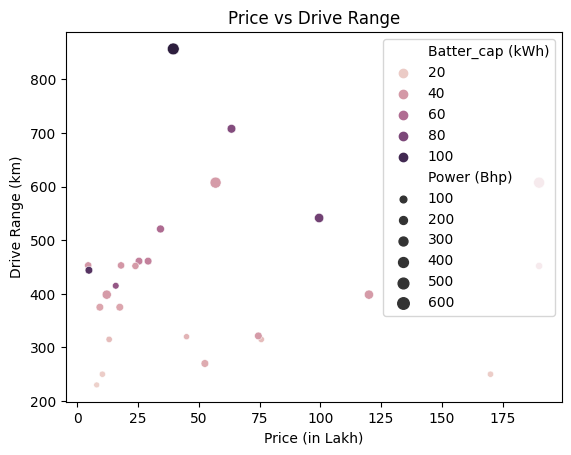

In [18]:

# Price vs Range
sns.scatterplot(data=df, x='Car_Price(in lk)', y='Drive Range (km)', hue='Batter_cap (kWh)', size='Power (Bhp)')
plt.title('Price vs Drive Range')
plt.xlabel('Price (in Lakh)')
plt.ylabel('Drive Range (km)')
plt.legend()
plt.show()



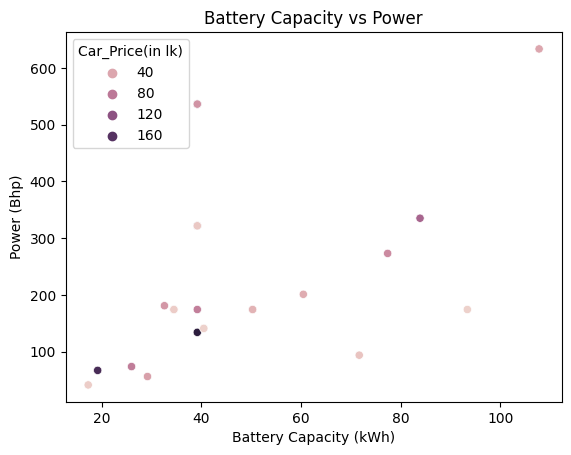

In [19]:
# Battery Capacity vs Power
sns.scatterplot(data=df, x='Batter_cap (kWh)', y='Power (Bhp)', hue='Car_Price(in lk)')
plt.title('Battery Capacity vs Power')
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('Power (Bhp)')
plt.show()


In [20]:
# Select relevant numeric columns for clustering
features = ['Car_Price(in lk)', 'Batter_cap (kWh)', 'Drive Range (km)', 
            'Power (Bhp)', 'Charge Time (hrs)']
df_numeric = df[features]

# Step 1: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)

#### Principal Component Analysis (PCA)

In [21]:
# Step 2: PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

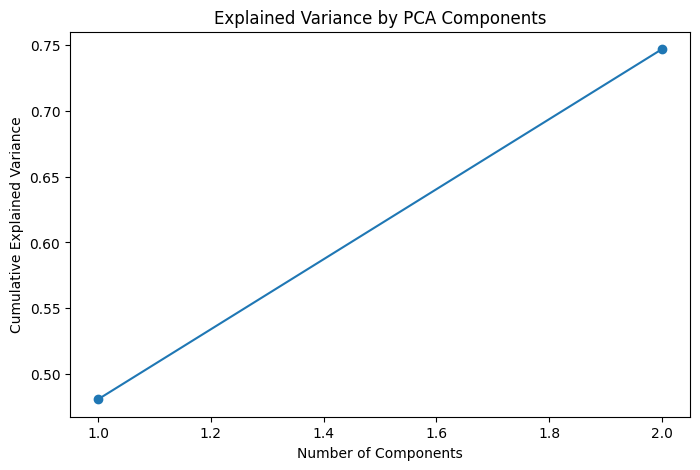

In [22]:
# Step 3: Plot explained variance to see the contribution of each PCA component
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

#### Finding Optimal Clusters (Elbow Method)


In [23]:
inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)


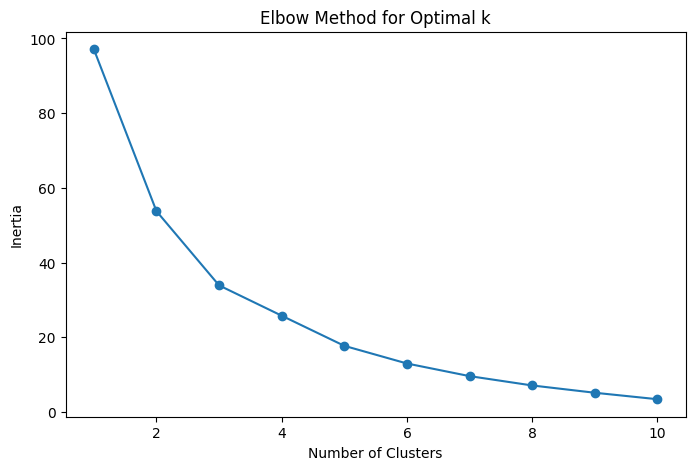

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [25]:
# Step 5: Apply KMeans Clustering 
optimal_k = 3  # Adjust based on the elbow curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(pca_data)

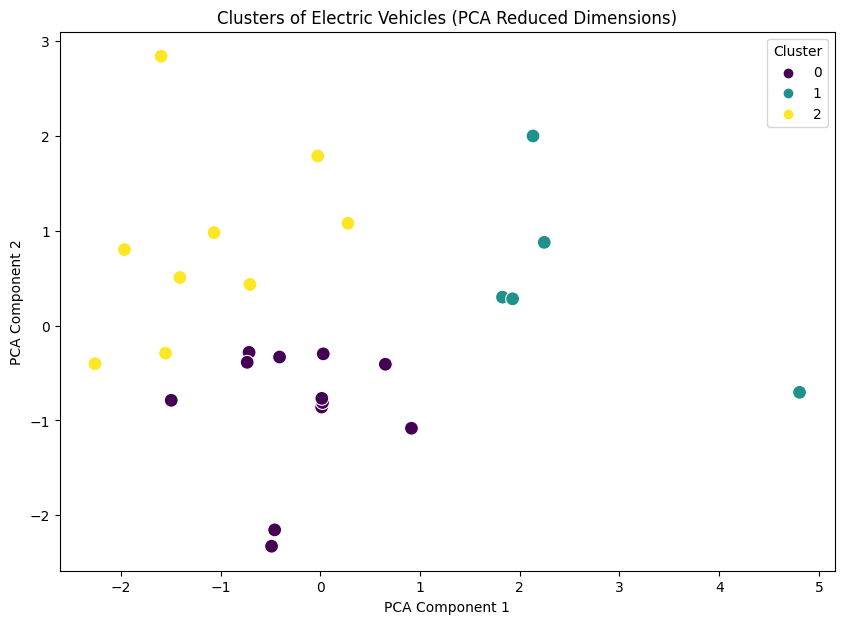

In [26]:
# Step 6: Visualize the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=clusters, palette='viridis', s=100)
plt.title('Clusters of Electric Vehicles (PCA Reduced Dimensions)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [27]:
df['Cluster'] = clusters

In [28]:
# Calculate mean of features for each cluster
cluster_means = df.groupby('Cluster')[features].mean()
print(cluster_means)


         Car_Price(in lk)  Batter_cap (kWh)  Drive Range (km)  Power (Bhp)  \
Cluster                                                                      
0               19.977083         48.648333        427.375000   163.409167   
1               89.870000         69.500000        664.300000   462.977000   
2               79.348889         28.655556        311.333333   126.034444   

         Charge Time (hrs)  
Cluster                     
0                 8.385000  
1                 4.988000  
2                 4.692593  


In [29]:
df.to_csv('processed_ev_dataset.csv', index=False)

Cluster 0: Focuses on affordable EVs that prioritize affordability over extreme performance. These could be ideal for everyday commuters with decent range.

Cluster 1: Represents the luxury EV segment with high performance, long range, and faster charging. This cluster will appeal to buyers who prioritize technology and luxury.

Cluster 2: Represents mid-tier EVs, balancing price and performance. These cars offer reasonable range and charging time, making them suitable for consumers who seek value without sacrificing too much in terms of features.